In [13]:
%pip install watermark
# 这是魔法命令 整个cell的第一行

You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [14]:
%load_ext watermark
# load_ext只能执行一次

In [16]:
%watermark -a 'Ester' -d -v -m -p numpy,pandas,matplotlib,scipy,sklearn

Ester 2020-04-14 

CPython 3.6.9
IPython 7.8.0

numpy 1.17.2
pandas 0.25.1
matplotlib 3.1.1
scipy 1.3.1
sklearn 0.21.3

compiler   : GCC 7.3.0
system     : Linux
release    : 5.0.0-37-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


### 概率分类器-Bayes分类器
算法得出的结论，永远不是100%确定的，更多的是判断出一种“样本标签更可能是个是某一类的可能性“

决策树： gini/entropy

LR：sigmoid函数压缩后的似然(接口predict_proba调用)

SVM：样本距离决策边界的距离（decision_function调用）

以上都是置信度，真正的概率分类器-Navie Bayes.
### 处理连续性变量
分箱：到底分多少箱难以决定->采用概率论中计算连续型变量的概率分布

### sklearn中的naive bayes
贝叶斯岭回归用的不多

虽然navie bayes的假设过于简化，但在实际情况中应用不错：如垃圾邮件过滤，文本分类。

由于navie bayes从概率角度进行估计，需要样本量较少；但显然对于所有机器学习算法来说，样本数量小于特征数目时，算法的效果和功能就会削弱；

与SVM和随机森林相比，naive bayes计算更快（并行计算，特征独立），predict_proba不是总是指向分类的结果

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

In [20]:
# GaussianNB
# P(xi|C)服从正态分布
# 基本不进行调参
# paras:
# - priors: P(C1) P(C2);
# - var_smoothing： 无效果，不添加；将所有特征中最大的方差以一定比例添加（var_smoothing）
# 过于简单
from sklearn.naive_bayes import GaussianNB

In [21]:
digits = load_digits()
X,y = digits.data, digits.target

In [22]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.3,random_state=420)

In [24]:
# 探索标签
np.unique(Ytrain) # 多分类问题，类别是10个

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [25]:
gnb = GaussianNB().fit(Xtrain,Ytrain)

In [27]:
# 查看分数acc
acc_score = gnb.score(Xtest,Ytest)
acc_score

0.8592592592592593

In [28]:
# 查看预测结果
Y_pred = gnb.predict(Xtest)

In [29]:
# 产看每个类别的概率
prob = gnb.predict_proba(Xtest)
prob.shape

(540, 10)

In [30]:
prob[1,:].sum()

1.000000000000003

In [31]:
prob.sum(axis=1).sum()  # 行数方向上加和

540.0

In [32]:
# 混淆矩阵
# 多分类下先看这个
from sklearn.metrics import confusion_matrix as CM
CM(Ytest, Y_pred)

array([[47,  0,  0,  0,  0,  0,  0,  1,  0,  0],
       [ 0, 46,  2,  0,  0,  0,  0,  3,  6,  2],
       [ 0,  2, 35,  0,  0,  0,  1,  0, 16,  0],
       [ 0,  0,  1, 40,  0,  1,  0,  3,  4,  0],
       [ 0,  0,  1,  0, 39,  0,  1,  4,  0,  0],
       [ 0,  0,  0,  2,  0, 58,  1,  1,  1,  0],
       [ 0,  0,  1,  0,  0,  1, 49,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 54,  0,  0],
       [ 0,  3,  0,  1,  0,  0,  0,  2, 55,  0],
       [ 1,  1,  0,  1,  2,  0,  0,  3,  7, 41]])

### 探索bayes：高斯朴素bayes擅长的数据集
- 参考svm中对核函数的考量

1.决策边界为弧线；

2.从图上看，高斯贝叶斯属于比较特殊的一类分类器，其分类效果再二分数据和月亮型数据上表现优秀，但是环形数据不太擅长；

3.之前的线性模型如LR和线性SVM绘制线性的决策边界，故难以对月亮型和环形数据进行区分，但naive bayes决策边界为弧线，所以往往在月亮型和环形数据上表现好。

4.但是由于naive bayes假设特征之间线性可分，与实际不符。

5.数据线性可分->LR, 不是线性可分->SVM. 轮不到朴素贝叶斯

In [ ]:
from sklearn.datasets import make_moons,make_circles,make_classification


### 比较高斯普斯贝叶斯，随机森林和SVM的拟合效果和运算速度

sklearn learning_curve

横：训练样本量， 纵：测试准确度

返回三组数据：横坐标，训练纵坐标，测试纵坐标

In [33]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from time import time
import datetime

In [42]:
def plot_learning_curve(estimator, title,X, y,
                        ax,  # 选定的子图
                        ylim=None,
                        cv=None,
                        n_jobs=None                        
                       ):
    # 输入： 分类器，数据，画图的参数，交叉验证的模式
    train_size, train_scores, test_scores = learning_curve(estimator # 分类器
                                                          , X, y
                                                          , cv=cv # 交叉验证模式
                                                          , n_jobs=n_jobs # 每次运行时可并行使用的线程，-1表示所有（谨慎使用）
                                                          )
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel('Training examples')
    ax.set_ylabel('Score')
    ax.grid()
    ax.plot(train_size, np.mean(train_scores, axis=1),'o-', color='r', label= 'training score')
    ax.plot(train_size, np.mean(test_scores, axis=1),'o-', color='g', label= 'testing score')
    ax.legend(loc='best')
    return ax
    
   
   
    
    

In [35]:
model = [GaussianNB(),
         SVC(kernel='linear', gamma=0.01),
        LR(C=0.1, solver='lbfgs'),
        DTC(),
        RFC(n_estimators=50, random_state=0)]
title = ['GNB','SVC','LR', 'DTC', 'RFC']
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)  # 50折验证


GNB:00:00:945926
SVC:00:02:935432
LR:00:15:621790
DTC:00:00:896317
RFC:00:07:609618


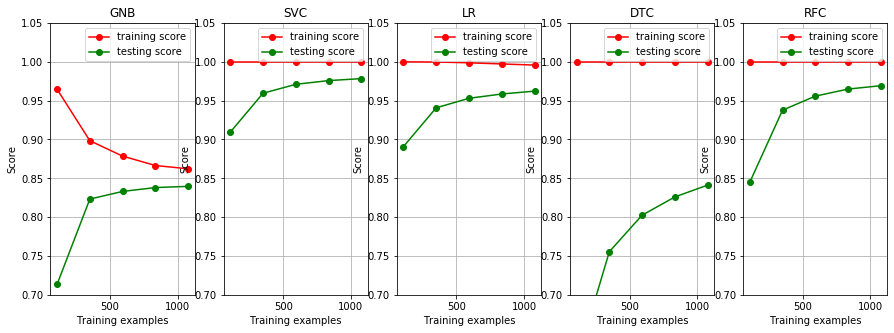

In [52]:
fig, axes = plt.subplots(1, 5, figsize=[15,5])
for i in range(len(model)):
    times = time()
    plot_learning_curve(model[i], title[i], X, y, axes[i],[0.7,1.05], cv, 4)
    print('{}:{}'.format(title[i], datetime.datetime.fromtimestamp(time()-times).strftime('%M:%S:%f')))
plt.show()

In [55]:
for ind, title_, model_ in zip(range(len(title)), title,model):
    times = time()
    plot_learning_curve(model_, title_, X, y, ax=axes[i], ylim=[0.7,1.05], cv=cv, n_jobs=4)
    print('{}:{}'.format(title_, datetime.datetime.fromtimestamp(time()-times).strftime('%M:%S:%f')))
plt.show()

GNB:00:00:726599
SVC:00:02:922720
LR:00:15:409580
DTC:00:00:726786
RFC:00:07:701336


In [56]:
[*zip(range(len(title)), title,model)]

[(0, 'GNB', GaussianNB(priors=None, var_smoothing=1e-09)),
 (1, 'SVC', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
      max_iter=-1, probability=False, random_state=None, shrinking=True,
      tol=0.001, verbose=False)),
 (2,
  'LR',
  LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                     warm_start=False)),
 (3,
  'DTC',
  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                         max_features=None, max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fr

### 比较分析
- 运算速度

决策树和朴素bayes差不多：每次分枝，随机选取特征来建树；但随着样本量增大，bayes快于决策树，原因在于bayes在样本量较少时训练效果与样本量大差别不大

LR再线性数据上好，但是特征过多，手写数字辨识受稀疏矩阵的影响， 运算速度较慢。

- 过拟合问题

bayes是通过训练集上的误差增大

- 泛化误差大小

DTC和NB的表现较差，但决策树可以通过剪枝来改善，但bayes的acc_score无论是通过增大样本量或是调参都无法改善，即只要给的数据量大，naive bayes在训练集上的表现就与其极限相似

>Conclusion：
1. bayes速度快，但效果一般，且初次训练的结果很接近极限，基本没有条参余地；
2. **概率预测**，越准越好->LR
3. 数据过于复杂，稀疏矩阵特征过多->bayes/方差过滤等特征选泽再使用LR
4. 特征过多且无法降维->Bayes,速度快
5. 仅对分类要求：DTC/Bayes测试集上效果好，congratulations！bad:换上更复杂的模型SVC/RFC




### 概率型评估指标
- brier_score_loss

In [65]:
np.unique(Ytest)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [66]:
from sklearn.metrics import brier_score_loss as bs
bs(Ytest, prob[:,3], pos_label=3) # 少数类的概率

ValueError: Only binary classification is supported. Labels in y_true: [0 1 2 3 4 5 6 7 8 9].